In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold

import tensorflow
from tensorflow import keras
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import kerastuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization

from ann_visualizer.visualize import ann_viz
import graphviz



sys.path.append("../Shared/")
from DataService import DataService

sys.path.append("../Datasets/")
# print(os.getcwd())
from DataCreation import getDatasetV1, getDatasetV2, getDatasetV3, getDatasetV4
from DataTestSplit import splitData



/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/.venv/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/.venv/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/tmp/ipykernel_987538/2652727627.py:10: DeprecationWarning:

In [2]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices

2023-07-28 13:46:29.505540: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-07-28 13:46:29.505563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: woodswallow-02.cs.umanitoba.ca
2023-07-28 13:46:29.505568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: woodswallow-02.cs.umanitoba.ca
2023-07-28 13:46:29.505641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-07-28 13:46:29.505660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 510.108.3
2023-07-28 13:46:29.505665: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 510.108.3 does not match DSO version 525.125.6 -- cannot find working 

In [3]:
from typing import List, Optional, Tuple
def extractYears(df: pd.DataFrame, year: int, yearEnd: Optional[int] = None) -> pd.DataFrame:
    """Extract the rows of a dataframe that correspond to a given year.

    Args:
        df (pd.DataFrame): The dataframe to extract from.
        year (int): The year to extract.
        yearEnd (int, optional): The end year to extract. Defaults to None.

    Returns:
        pd.DataFrame: The extracted dataframe.
    """
    
    if yearEnd is None:
        return df.loc[df["year"] == year]
    else:
        return df.loc[(df["year"] >= year) & (df["year"] <= yearEnd)]

In [4]:
load_dotenv()
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")

if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    raise ValueError("Environment variables not set")

# connecting to database
db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
conn = db.connect()

In [5]:
weatherStationQuery = sq.text("""
    SELECT * from dataset_cross_monthly_station
""")

weatherSatQuery = sq.text("""
    SELECT * from dataset_monthly_sat
""")

ergotPrevYearsAggQuery = sq.text("""
    SELECT year, district, 
    present_prev1, present_prev2, present_prev3,
    percnt_true_prev1, percnt_true_prev2, percnt_true_prev3 
    from agg_ergot_sample_v2
""")

ergotTargetQuery = sq.text("""
    SELECT year, district, downgrade from ergot_sample_feat_eng
""")

In [6]:
stationDf = pd.read_sql(weatherStationQuery, conn)
satelliteDf = pd.read_sql(weatherSatQuery, conn)
ergotPrevDf = pd.read_sql(ergotPrevYearsAggQuery, conn)
ergotTargetDf = pd.read_sql(ergotTargetQuery, conn)

conn.close()
del conn

In [7]:
ergotTargetDf.drop_duplicates( inplace=True)
ergotTargetDf

,year,district,downgrade
0,1995,4810,False
48,1995,4820,False
190,1995,4830,False
230,1995,4840,False
280,1995,4840,True
...,...,...,...
157041,2022,4751,True
157126,2022,4791,True
157219,2022,4731,True
157727,2022,4604,True


In [8]:
ergotPrevDf.fillna(0, inplace=True)
ergotPrevDf

,year,district,present_prev1,present_prev2,present_prev3,percnt_true_prev1,percnt_true_prev2,percnt_true_prev3
0,1995,4810,False,False,False,0.000000,0.000000,0.000000
1,1995,4820,False,False,False,0.000000,0.000000,0.000000
2,1995,4830,False,False,False,0.000000,0.000000,0.000000
3,1995,4840,False,False,False,0.000000,0.000000,0.000000
4,1995,4850,False,False,False,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
1087,2022,4761,False,True,True,0.010204,0.076923,0.062893
1088,2022,4771,False,True,False,0.000000,0.153333,0.013072
1089,2022,4790,True,True,True,0.025316,0.229167,0.147727
1090,2022,4791,False,True,True,0.028986,0.223881,0.328571


In [9]:
stationDf

,year,district,1:min_temp_x,1:max_temp_x,1:mean_temp_x,1:min_dew_point_temp,1:max_dew_point_temp,1:mean_dew_point_temp,1:min_humidex,1:max_humidex,...,12:mean_total_rain,12:min_total_snow,12:max_total_snow,12:mean_total_snow,12:min_total_precip,12:max_total_precip,12:mean_total_precip,12:min_snow_on_grnd,12:max_snow_on_grnd,12:mean_snow_on_grnd
0,1953,4606,-37.2,-3.3,-16.650918,-22.2,0.0,-3.170833,0.0,0.0,...,0.0,0.0,10.2,1.047826,0.0,10.2,1.047826,0.0,0.0,0.000000
1,1953,4607,-31.7,-4.4,-14.224855,-33.9,-5.0,-14.939367,0.0,0.0,...,0.0,0.0,3.3,0.508696,0.0,3.3,0.508696,0.0,0.0,0.000000
2,1953,4611,-31.7,-5.0,-13.608918,-32.2,-5.6,-14.508056,0.0,0.0,...,0.0,0.0,2.3,0.231818,0.0,2.3,0.231818,0.0,0.0,0.000000
3,1953,4612,-38.9,-7.2,-23.922143,-40.0,0.0,-23.888548,0.0,0.0,...,0.0,0.0,20.3,1.161905,0.0,20.3,1.161905,0.0,0.0,0.000000
4,1953,4710,-33.9,3.3,-11.815733,-33.9,-1.1,-12.818630,0.0,0.0,...,0.0,0.0,3.3,0.191304,0.0,3.3,0.191304,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2022,4605,-36.8,1.7,-18.537634,-40.7,-1.0,-21.749866,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,9.3,0.879310,12.0,29.0,17.275862
2656,2022,4604,-37.6,-0.1,-18.692339,-41.0,-0.8,-21.278898,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,11.1,0.700000,10.0,36.0,18.966667
2657,2022,4771,-36.7,3.2,-14.102554,-41.9,-1.0,-17.953763,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,6.0,0.706667,4.0,7.0,4.966667
2658,2022,4609,-35.4,-0.8,-18.504344,-39.3,-1.9,-22.128021,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,10.2,0.566667,0.0,17.0,2.988889


In [10]:
# merge on year and district
# tempdf = pd.merge(satelliteDf, ergotPrevDf, on=["year", "district"], how="left")
# del satelliteDf
# del ergotPrevDf
# tempdf = satelliteDf
tempdf = stationDf

# merge on year and district
datasetDf = pd.merge(ergotTargetDf, tempdf, on=["year", "district"], how="left")
datasetDf = pd.merge(datasetDf, ergotPrevDf, on=["year", "district"], how="left")
del ergotTargetDf
del tempdf

In [11]:
datasetDf

,year,district,downgrade,1:min_temp_x,1:max_temp_x,1:mean_temp_x,1:min_dew_point_temp,1:max_dew_point_temp,1:mean_dew_point_temp,1:min_humidex,...,12:mean_total_precip,12:min_snow_on_grnd,12:max_snow_on_grnd,12:mean_snow_on_grnd,present_prev1,present_prev2,present_prev3,percnt_true_prev1,percnt_true_prev2,percnt_true_prev3
0,1995,4810,False,-29.5,11.1,-10.052509,-31.9,4.8,-12.584334,0.0,...,0.312903,0.0,23.0,6.011290,False,False,False,0.000000,0.000000,0.000000
1,1995,4820,False,-29.0,11.7,-9.005317,-33.2,3.7,-12.199939,0.0,...,0.224424,0.0,20.0,2.594470,False,False,False,0.000000,0.000000,0.000000
2,1995,4830,False,-31.8,19.9,-6.828269,-35.1,19.8,-11.597711,0.0,...,0.669804,0.0,32.0,6.696544,False,False,False,0.000000,0.000000,0.000000
3,1995,4840,False,-32.3,9.1,-13.498673,-36.5,1.7,-16.322788,0.0,...,0.363011,0.0,26.0,7.910753,False,False,False,0.000000,0.000000,0.000000
4,1995,4840,True,-32.3,9.1,-13.498673,-36.5,1.7,-16.322788,0.0,...,0.363011,0.0,26.0,7.910753,False,False,False,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2022,4751,True,-36.6,0.0,-15.998656,-41.3,-1.8,-19.096774,0.0,...,0.703333,1.0,11.0,5.500000,True,True,True,0.037736,0.327044,0.033520
1629,2022,4791,True,-42.5,6.4,-15.841629,-47.0,0.2,-18.980527,0.0,...,0.650833,0.0,54.0,20.408333,False,True,True,0.028986,0.223881,0.328571
1630,2022,4731,True,-35.8,5.0,-10.639516,-40.7,0.5,-14.229794,0.0,...,0.370000,0.0,24.0,5.688889,False,True,False,0.000000,0.195122,0.021277
1631,2022,4604,True,-37.6,-0.1,-18.692339,-41.0,-0.8,-21.278898,0.0,...,0.700000,10.0,36.0,18.966667,False,True,False,0.000000,0.288288,0.018519


In [12]:
mean = datasetDf.mean()
datasetDf.fillna(mean, inplace=True)
t = pd.get_dummies(datasetDf["district"], drop_first=True)
datasetDf = pd.concat([datasetDf, t], axis=1)
datasetDf.columns = datasetDf.columns.astype(str)

In [13]:
df = datasetDf.copy()

In [14]:
datasetDf.duplicated().sum()
datasetDf.drop_duplicates(inplace=True)

In [15]:
# train 1995 - 2015 test 2016 - 2020
X_train, X_val, X_test, y_train, y_val, y_test = splitData(datasetDf, drop_features=["year"], target_variable="downgrade", pivot=2015, val_size=0.2, stratified=False)
del datasetDf

/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/src/Models/../Datasets/DataTestSplit.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=drop_features, inplace=True)
/home/student/dodhiajk/CGC_Grain_Outcome_Predictions/src/Models/../Datasets/DataTestSplit.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=drop_features, inplace=True)


In [16]:
X_train.describe()

,district,1:min_temp_x,1:max_temp_x,1:mean_temp_x,1:min_dew_point_temp,1:max_dew_point_temp,1:mean_dew_point_temp,1:min_humidex,1:max_humidex,1:mean_humidex,...,4781,4790,4791,4810,4820,4830,4840,4850,4860,4870
count,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.0,934.000000,934.000000,...,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000,934.000000
mean,4724.273019,-34.022189,5.629123,-13.418105,-37.774227,0.943853,-15.567356,0.0,0.289384,0.000181,...,0.028908,0.029979,0.021413,0.023555,0.027837,0.024625,0.032120,0.032120,0.027837,0.025696
std,86.974669,9.493463,4.776416,5.425128,10.426951,2.524604,5.832694,0.0,2.896713,0.002757,...,0.167638,0.170620,0.144835,0.151738,0.164595,0.155063,0.176413,0.176413,0.164595,0.158311
min,4601.000000,-48.700000,-5.900000,-25.736550,-55.000000,-7.300000,-29.131354,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4609.000000,-39.200000,2.725000,-17.021684,-43.375000,0.000000,-19.306368,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4740.000000,-35.700000,4.900000,-14.213140,-39.800000,0.700000,-16.295296,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4781.000000,-32.150000,7.875000,-10.320856,-36.300000,1.675000,-12.705660,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4870.000000,0.000000,28.800000,0.000000,0.000000,19.800000,0.000000,0.0,32.000000,0.051747,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934 entries, 591 to 1126
Columns: 477 entries, district to 4870
dtypes: bool(3), float64(435), int64(1), uint8(38)
memory usage: 3.2 MB


In [33]:
df= test_df.copy()

In [34]:
TARGET = "downgrade"
df[TARGET] = df[TARGET].astype(int) # 0: Flase, 1: True
t = pd.get_dummies(df["district"], drop_first=True)
df = pd.concat([df, t], axis=1)
df.columns = df.columns.astype(str)
df.drop_duplicates(inplace=True)

In [35]:
df.shape

(324680, 92)

### getting data

In [5]:
months = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [42]:
TARGET = "downgrade"

# df = getDatasetV4(months)
df[TARGET] = df[TARGET].astype(int) # 0: Flase, 1: True
t = pd.get_dummies(df["district"], drop_first=True)
df = pd.concat([df, t], axis=1)
df.columns = df.columns.astype(str)
df.drop_duplicates(inplace=True)
# df.drop(["severity"], axis=1, inplace=True)
df

,year,district,downgrade,1:min_temp_x,1:max_temp_x,1:mean_temp_x,1:min_dew_point_temp,1:max_dew_point_temp,1:mean_dew_point_temp,1:min_humidex,...,4781,4790,4791,4810,4820,4830,4840,4850,4860,4870
0,1995,4810,0,-29.5,11.1,-10.052509,-31.9,4.8,-12.584334,0.0,...,0,0,0,1,0,0,0,0,0,0
48,1995,4820,0,-29.0,11.7,-9.005317,-33.2,3.7,-12.199939,0.0,...,0,0,0,0,1,0,0,0,0,0
190,1995,4830,0,-31.8,19.9,-6.828269,-35.1,19.8,-11.597711,0.0,...,0,0,0,0,0,1,0,0,0,0
230,1995,4840,0,-32.3,9.1,-13.498673,-36.5,1.7,-16.322788,0.0,...,0,0,0,0,0,0,1,0,0,0
280,1995,4840,1,-32.3,9.1,-13.498673,-36.5,1.7,-16.322788,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157041,2022,4751,1,-36.6,0.0,-15.998656,-41.3,-1.8,-19.096774,0.0,...,0,0,0,0,0,0,0,0,0,0
157126,2022,4791,1,-42.5,6.4,-15.841629,-47.0,0.2,-18.980527,0.0,...,0,0,1,0,0,0,0,0,0,0
157219,2022,4731,1,-35.8,5.0,-10.639516,-40.7,0.5,-14.229794,0.0,...,0,0,0,0,0,0,0,0,0,0
157727,2022,4604,1,-37.6,-0.1,-18.692339,-41.0,-0.8,-21.278898,0.0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df.columns

Index(['year', 'district', 'downgrade', '1:min_temp_x', '1:max_temp_x',
       '1:mean_temp_x', '1:min_dew_point_temp', '1:max_dew_point_temp',
       '1:mean_dew_point_temp', '1:min_humidex',
       ...
       '4781', '4790', '4791', '4810', '4820', '4830', '4840', '4850', '4860',
       '4870'],
      dtype='object', length=473)

In [35]:
df.drop(columns=["percnt_true", "has_ergot", "median_severity", "sum_severity", "present_in_neighbor", "sum_severity_in_neighbor", "severity_in_neighbor", "ergot_present_in_q1", "ergot_present_in_q2", "ergot_present_in_q3"
                 , "ergot_present_in_q4", "sum_severity_in_q1", "sum_severity_in_q2", "sum_severity_in_q3", "sum_severity_in_q4"], inplace=True)

In [36]:
df.corr()[TARGET]

year            -0.000067
district        -0.041976
present_prev1   -0.085820
present_prev2   -0.061270
present_prev3   -0.059122
                   ...   
4830            -0.025880
4840            -0.074334
4850            -0.053827
4860             0.026020
4870             0.005319
Name: sellable, Length: 78, dtype: float64

In [37]:
# df.drop(["severity"], axis=1, inplace=True)

### splitting data

In [44]:
# split data into train, validate and test
# TARGET = 'has_ergot'
PIVOT = 2019

In [45]:
# split datframe till 2018
df_train = df[df['year'] < PIVOT]
df_train.drop(columns=['year', 'district'], inplace=True)
X_train_df = df_train.drop(columns=[TARGET])
y_train_df = df_train[TARGET]

# X_train_df

/tmp/ipykernel_950805/1330982459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['year', 'district'], inplace=True)


In [46]:
#split dataframe from 2019
df_test = df[df['year'] >= PIVOT]
df_test.drop(columns=['year', 'district'], inplace=True)
X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]

X_test

/tmp/ipykernel_950805/2722088680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['year', 'district'], inplace=True)


,1:min_temp_x,1:max_temp_x,1:mean_temp_x,1:min_dew_point_temp,1:max_dew_point_temp,1:mean_dew_point_temp,1:min_humidex,1:max_humidex,1:mean_humidex,1:min_precip,...,4781,4790,4791,4810,4820,4830,4840,4850,4860,4870
140300,-30.5,6.2,-12.900874,-34.9,0.0,-15.673723,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
140301,-33.6,2.9,-16.098790,-37.4,0.3,-18.695699,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
140302,-39.7,3.3,-17.116263,-44.1,-0.4,-20.042204,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
140303,-30.0,15.0,-7.266595,-33.1,2.5,-10.345838,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
140304,-41.3,8.5,-11.641080,-45.6,2.7,-14.292471,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157041,-36.6,0.0,-15.998656,-41.3,-1.8,-19.096774,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
157126,-42.5,6.4,-15.841629,-47.0,0.2,-18.980527,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
157219,-35.8,5.0,-10.639516,-40.7,0.5,-14.229794,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
157727,-37.6,-0.1,-18.692339,-41.0,-0.8,-21.278898,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# now we treat the train data as a whole and split it into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=0.2, random_state=42)

In [137]:
y_train.value_counts()

False    6824
True     3704
Name: downgrade, dtype: int64

### scaling and oversampling

In [18]:
# normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# oversampling data
ros = RandomOverSampler(random_state=42)
X_train_rs, y_train_rs = ros.fit_resample(X_train, y_train)

In [19]:
y_train.value_counts()

False    601
True     333
Name: downgrade, dtype: int64

In [20]:
y_train_rs.value_counts()

False    601
True     601
Name: downgrade, dtype: int64

### Model

In [21]:
from sklearn import metrics
from keras import backend as K

def auc(y_true, y_pred):
    auc = tensorflow.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tensorflow.local_variables_initializer())
    return auc

In [22]:
def build_model(hp):
    model = Sequential()
    # model.add(Dense(input_dim=X_train.shape[1]))
    for i in range(hp.Int('num_layers', 2, 30)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=124, #32
                                            max_value=1748, # 512
                                            step=32),
                                activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid']),# , 'tanh', 'elu', 'selu', 'softplus', 'softsign', 'exponential', 'linear'])))
                                # kernel_regularizer = hp.Choice('kr_'+str(i), ['l2(0.01)', 'l1(0.01)', "l1_l2(0.01)"])))
                                kernel_regularizer = l1_l2(0.01)))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])
    return model

In [23]:
directory_path = 'data/random_search/'

if os.path.exists(directory_path):
    os.removedirs(directory_path)
    

# tuner = RandomSearch(
#     build_model,
#     objective=kt.Objective("val_auc", direction="max"),
#     max_trials=5,
#     executions_per_trial=3,
#     overwrite=True,
#     directory='data/random_search',
#     project_name='ergot_random_search'
#     )

tuner = BayesianOptimization(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_trials=10,
    overwrite=True,
    executions_per_trial=3,
    directory='data/BayesianOptimization',
    project_name='ergot_random_search')

In [24]:
tuner.search_space_summary()
# tuner2.search_space_summary()


Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 30, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 124, 'max_value': 1748, 'step': 32, 'sampling': 'linear'}
act_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 124, 'max_value': 1748, 'step': 32, 'sampling': 'linear'}
act_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
tuner.search(X_train_rs, y_train_rs, epochs=10, validation_data=(X_val, y_val), batch_size=64)
# tuner2.search(X_train_rs, y_train_rs, epochs=100, validation_data=(X_val, y_val))

Trial 10 Complete [00h 00m 45s]
val_auc: 0.5

Best val_auc So Far: 0.5296452840169271
Total elapsed time: 00h 09m 32s
INFO:tensorflow:Oracle triggered exit


In [26]:
tuner.results_summary()

Results summary
Results in data/BayesianOptimization/ergot_random_search
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 01 summary
Hyperparameters:
num_layers: 2
units_0: 1724
act_0: relu
units_1: 284
act_1: relu
learning_rate: 0.01
units_2: 1084
act_2: sigmoid
units_3: 156
act_3: relu
Score: 0.5296452840169271

Trial 00 summary
Hyperparameters:
num_layers: 4
units_0: 1404
act_0: sigmoid
units_1: 1692
act_1: relu
learning_rate: 0.01
units_2: 124
act_2: relu
units_3: 124
act_3: relu
Score: 0.5

Trial 02 summary
Hyperparameters:
num_layers: 22
units_0: 316
act_0: sigmoid
units_1: 1532
act_1: relu
learning_rate: 0.0001
units_2: 732
act_2: sigmoid
units_3: 252
act_3: relu
units_4: 124
act_4: relu
units_5: 124
act_5: relu
units_6: 124
act_6: relu
units_7: 124
act_7: relu
units_8: 124
act_8: relu
units_9: 124
act_9: relu
units_10: 124
act_10: relu
units_11: 124
act_11: relu
units_12: 124
act_12: relu
units_13: 124
act_13: relu
units_14: 124
act_14: relu
units_15: 12

In [146]:
# model = Sequential()

# model.add(Dense(64, activation='relu' ,input_dim=X_train.shape[1])) #, kernel_regularizer=l2(0.01)
# # model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid')) # , kernel_regularizer=l2(0.01)

# model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
model = tuner.get_best_models(num_models=1)[0]
model.build(X_train.shape)

In [77]:
from keras.activations import relu, sigmoid

model = Sequential()
model.add(Dense(448, activation='sigmoid' ,input_dim=X_train.shape[1]))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
model.summary()
model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (934, 1724)               824072    
                                                                 
 dense_1 (Dense)             (934, 284)                489900    
                                                                 
 dense_2 (Dense)             (934, 1)                  285       
                                                                 
Total params: 1,314,257
Trainable params: 1,314,257
Non-trainable params: 0
_________________________________________________________________


In [76]:
# ann_viz(model, title="Ergot Model")
# graph_file = graphviz.Source.from_file('network.gv')


In [77]:
# graph_file

In [34]:
history = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=64, validation_data=(X_val, y_val), verbose=1)
# history = model.fit(X_train_rs, y_train_rs, epochs=500, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/500
 1/19 [>.............................] - ETA: 0s - loss: 16.9879 - accuracy: 0.4531 - auc: 0.5000

19/19 [==============================] - 0s 12ms/step - loss: 16.8541 - accuracy: 0.5000 - auc: 0.4899 - val_loss: 16.9918 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/500
19/19 [==============================] - 0s 11ms/step - loss: 16.8406 - accuracy: 0.5000 - auc: 0.5195 - val_loss: 16.6638 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/500
19/19 [==============================] - 0s 12ms/step - loss: 16.8404 - accuracy: 0.5000 - auc: 0.4614 - val_loss: 16.8334 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 4/500
19/19 [==============================] - 0s 11ms/step - loss: 16.8583 - accuracy: 0.5000 - auc: 0.4859 - val_loss: 16.6466 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 5/500
19/19 [==============================] - 0s 11ms/step - loss: 16.8104 - accuracy: 0.5000 - auc: 0.4983 - val_loss: 17.2420 - val_accuracy: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 6/500
19/19 [==============================] - 0s 10ms/step - loss: 16.8225 - accuracy

KeyboardInterrupt: 

In [80]:
def evaluate_model(history):
    # Get the training and validation loss from the history
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get the training and validation accuracy from the history
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Plot the training and validation loss
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    # Check if the model is overfitting, underfitting, or performing well
    # final_training_loss = np.array(training_loss).mean()
    # final_validation_loss = np.array(validation_loss).mean()

    # final_training_accuracy = np.array(training_accuracy).mean()
    # final_validation_accuracy = np.array(validation_accuracy).mean()

    # if final_training_loss < final_validation_loss:
    #     print("The model is likely underfitting.")
    # elif final_training_loss > final_validation_loss:
    #     print("The model is likely overfitting.")
    # else:
    #     print("The model is performing well and generalizing to new data.")

    # if final_training_accuracy == 1.0 and final_validation_accuracy == 1.0:
    #     print("The model has achieved 100% accuracy on both training and validation data.")

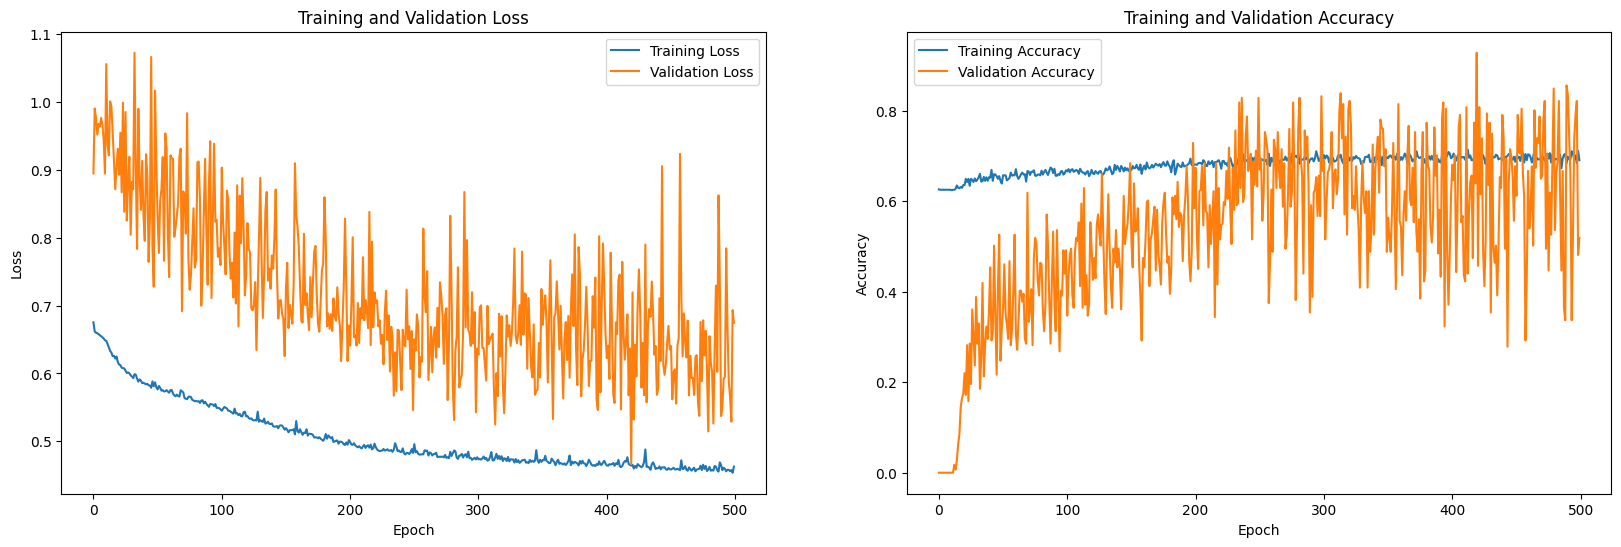

In [81]:
evaluate_model(history)

In [34]:
model.save('data/ergot_model.h5')

###  pred

In [29]:
y_log = model.predict(X_val)
y_pred = np.where(y_log > 0.5, 1, 0)

8/8 [==============================] - 0s 1ms/step


In [30]:
conf_matrix = confusion_matrix(y_val, y_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_val, y_pred)
print("AUC Score: ", auc_score)

# print(classification_report(y_val, y_pred))

Accuracy:  0.5854700854700855
Precision:  0.3763440860215054
Recall:  0.47297297297297297
F1 Score:  0.4191616766467066
AUC Score:  0.5552364864864865


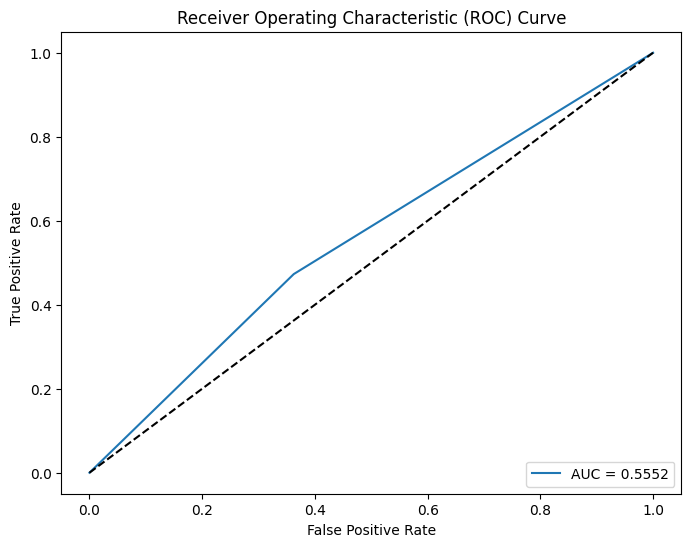

In [31]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# d1
[64, 16, 8, 4, 1]
- Accuracy:  0.7759562841530054
- Precision:  0.8767123287671232
- Recall:  0.847682119205298
- F1 Score:  0.861952861952862
- AUC Score:  0.642591059602649

[48, 48, 48, 48, 1]
- Accuracy:  0.7978142076502732
- Precision:  0.9014084507042254
- Recall:  0.847682119205298
- F1 Score:  0.8737201365187712
- AUC Score:  0.705091059602649

In [32]:
# main prediction

y_main_log = model.predict(X_test)
y_main_pred = np.where(y_main_log > 0.5, 1, 0)

conf_matrix = confusion_matrix(y_test, y_main_pred)

accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
print("Accuracy: ", accuracy)

precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
print("Precision: ", precision)

recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
print("Recall: ", recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score: ", f1_score)

auc_score = roc_auc_score(y_test, y_main_pred)
print("AUC Score: ", auc_score)

# print(classification_report(y_test, y_main_pred))

 1/15 [=>............................] - ETA: 0s

15/15 [==============================] - 0s 1ms/step
Accuracy:  0.5956989247311828
Precision:  0.4125874125874126
Recall:  0.3619631901840491
F1 Score:  0.38562091503267976
AUC Score:  0.5419087474099055


### get weights

In [ ]:
def plot_feature_importance(model, feature_names):
    # Get the weights of the first hidden layer
    first_hidden_layer_weights = model.layers[0].get_weights()[0]
    
    # Calculate the mean absolute weight for each feature
    feature_importance = np.mean(np.abs(first_hidden_layer_weights), axis=1)
    
    # Sort the features based on their importance
    sorted_indices = np.argsort(feature_importance)[::-1]
    sorted_feature_importance = feature_importance[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    
    # Plot the feature importance
    plt.figure(figsize=(20, 6))
    plt.bar(range(len(feature_names)), sorted_feature_importance)
    plt.xticks(range(len(feature_names)), sorted_feature_names, rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.title('Feature Importance of MLP')
    plt.tight_layout()
    plt.show()


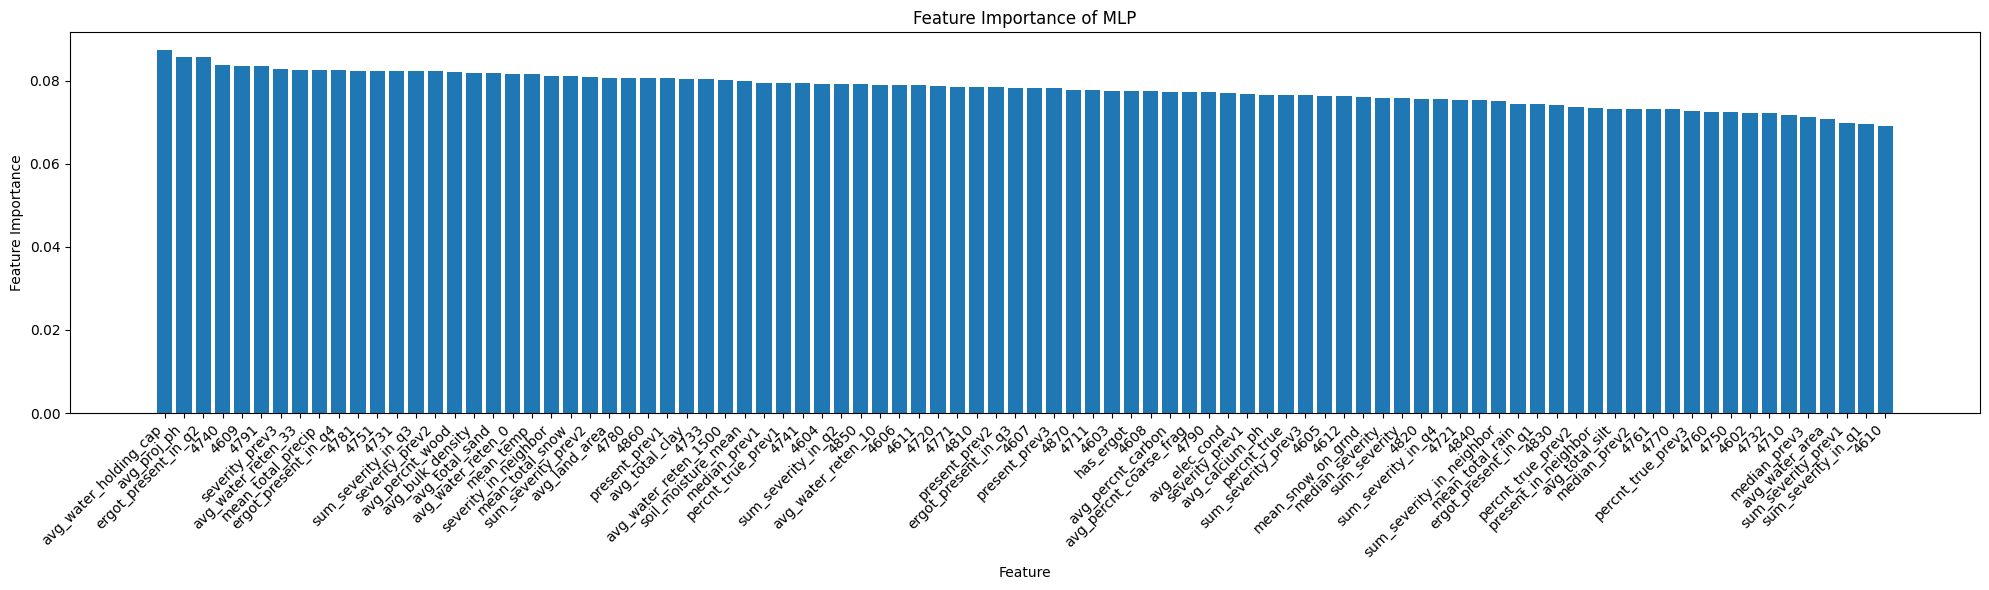

In [ ]:
plot_feature_importance(model, X_train_df.columns)